# Denoising MNIST with U-Net

In this script, we are denoising mnist samples using segmentation. This is just a small usecase of the unet used later in DDPMs. 

Using original structure (segmentation):

The idea is to segment "written" (white) from "background" (black) data, while training on different noise scales and obtaining the ground truth by thresholding.
* class 0 (background): pixelvalue < 0.5
* class 1 (written digit): pixelvalue >= 0.5

Using modified structure (image output):
* remove n_classes from Unet and output n_channels --> only image prediction
* this model is used for DDPMs too


Both ways converge to similar solution, however the first one looks cleaner since the model outputs a classification of pixels if threshold is applied.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

transform = torchvision.transforms.transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST('./../data', train=True, transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torchvision.datasets.MNIST('./../data', train=False, transform=transform, download=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

Device: cuda:0


### Training Loop

In [ ]:
from simple_unet import SimpleSegmentationUNet, SimpleUNet
import matplotlib.pyplot as plt
import numpy as np

# model = SimpleSegmentationUNet(n_channels=1, n_classes=1)
model = SimpleUNet(n_channels=1)
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
mse = torch.nn.MSELoss()
threshold = 0.5

T = 1000
beta_schedule = np.linspace(start=1e-4, stop=0.02, num=T)
alpha_cumprod = np.cumprod(1 - beta_schedule) 

def preprocess(batch):

    # Noise creation equivalent to DDPMs
    t = np.random.randint(int(T*0),T, size=(batch.shape[0]))
    noise = np.random.normal(size=batch.shape)
    alpha = alpha_cumprod[t]
    xt = batch.cpu().detach().numpy().copy()
    for j in range(xt.shape[0]):
        xt[j] = np.sqrt(alpha[j]) * batch[j] + (1-alpha[j]) * noise[j] # in terms of x0
    xt = torch.tensor(xt)

    return xt

def train_one_epoch(epoch_number, iterations_per_epoch=500):

    running_loss = 0.
    last_loss = 0.

    for i, (batch, labels) in enumerate(train_dataloader):

        if i >= iterations_per_epoch:
            break

        ground_truth = torch.round(batch)
        ground_truth = ground_truth.to(device)

        xt = preprocess(batch)
        xt = xt.to(device)
        
        optimizer.zero_grad()

        prediction = model(xt)

        loss = mse(prediction,ground_truth)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % iterations_per_epoch == iterations_per_epoch-1:

            # training loss
            last_loss = running_loss / iterations_per_epoch # loss per batch
            # print('Iteration {} loss: {}'.format(epoch_number*iterations_per_epoch + i+1, last_loss))
            print('Iteration {}'.format(epoch_number*iterations_per_epoch + i+1))
            running_loss = 0.

            # training results so far
            concat = torch.concat((xt, ground_truth, prediction), dim=1)
            imgs = torchvision.utils.make_grid(concat).detach().cpu().numpy()
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes = axes.flatten()
            for k, (img, title) in enumerate(zip(imgs,['noisy input', 'ground truth', 'prediction handwritten'])):
                axes[k].imshow(img)
                axes[k].set_title(title)
                axes[k].axis('off')
            plt.show()

    return last_loss


EPOCH 1:
Iteration 200


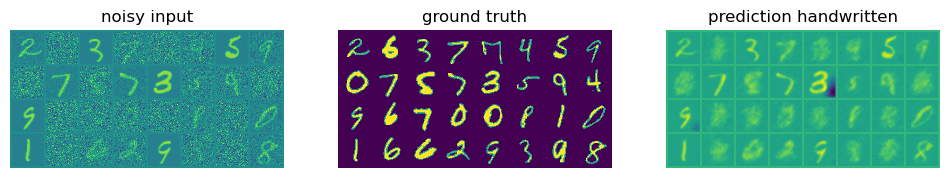

LOSS train 1.0367392164468765 valid 0.8783608078956604
EPOCH 2:
Iteration 400


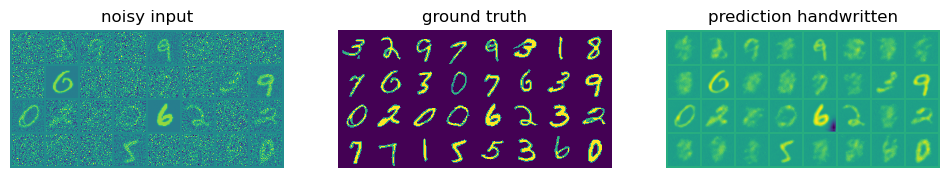

LOSS train 0.6911962339282036 valid 0.6512941718101501
EPOCH 3:
Iteration 600


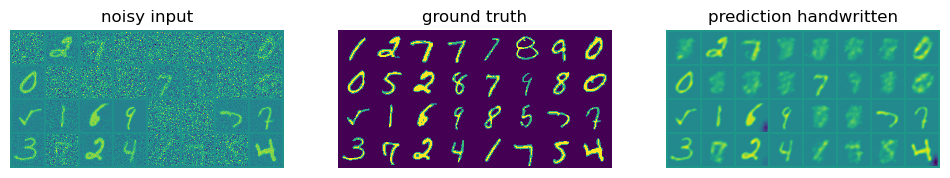

LOSS train 0.5483228908479214 valid 0.5262055397033691
EPOCH 4:
Iteration 800


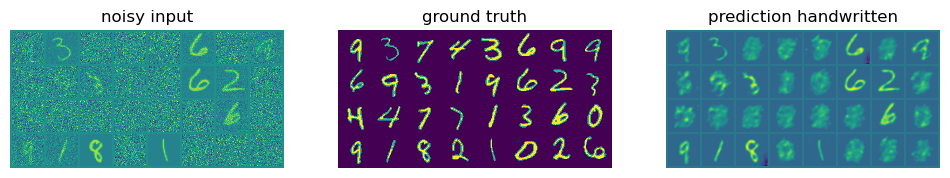

LOSS train 0.45786268517374995 valid 0.4287811815738678
EPOCH 5:
Iteration 1000


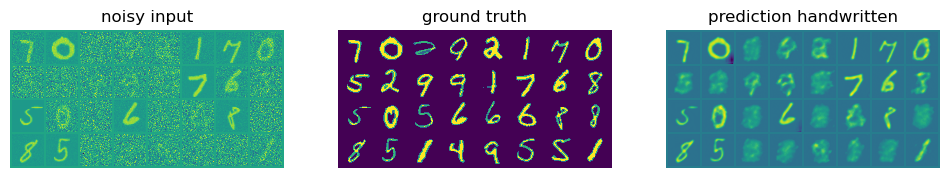

LOSS train 0.39322012931108474 valid 0.3791561424732208
EPOCH 6:
Iteration 1200


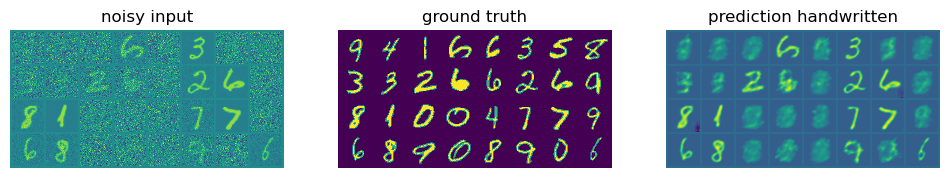

LOSS train 0.3555813165009022 valid 0.3455328941345215
EPOCH 7:
Iteration 1400


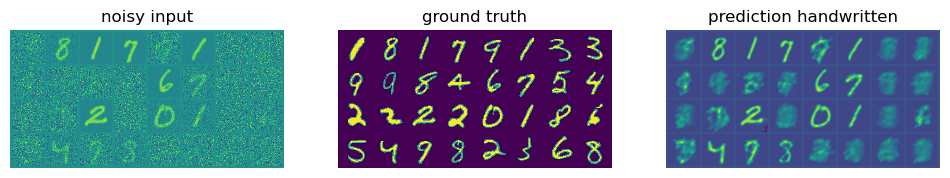

LOSS train 0.331785943582654 valid 0.3290534019470215
EPOCH 8:
Iteration 1600


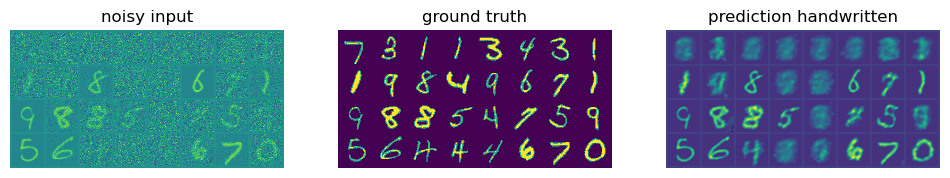

LOSS train 0.3132512458413839 valid 0.30867743492126465
EPOCH 9:
Iteration 1800


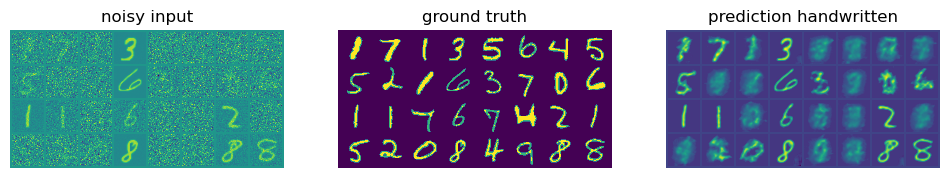

LOSS train 0.2968109387159348 valid 0.2994404435157776
EPOCH 10:
Iteration 2000


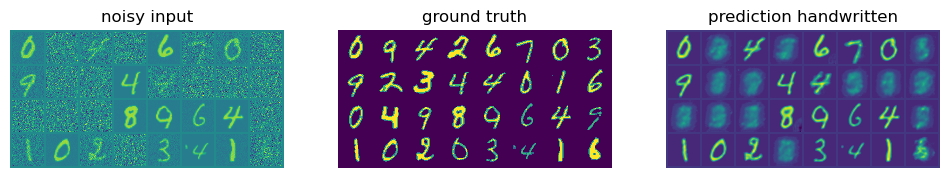

LOSS train 0.29404872000217436 valid 0.2859226167201996
EPOCH 11:
Iteration 2200


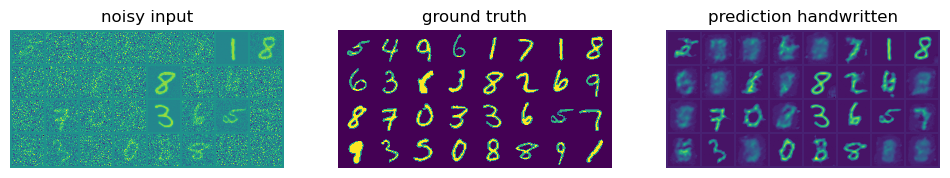

LOSS train 0.2848340751975775 valid 0.28270047903060913
EPOCH 12:
Iteration 2400


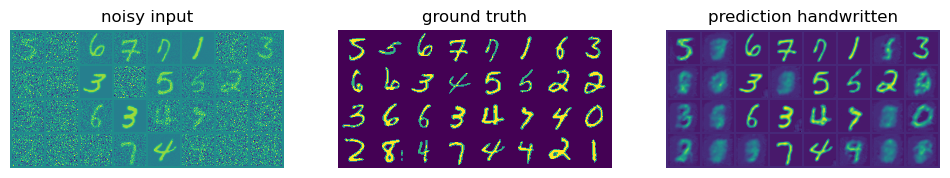

LOSS train 0.28061407946050165 valid 0.27453604340553284
EPOCH 13:
Iteration 2600


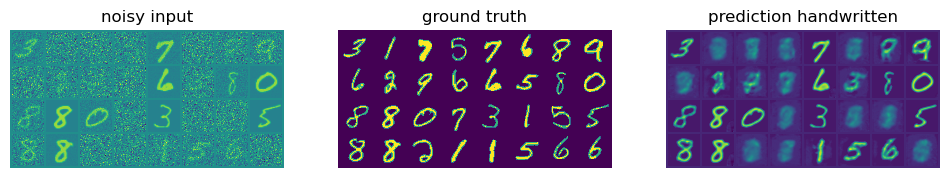

LOSS train 0.2820980973541737 valid 0.2763877213001251
EPOCH 14:
Iteration 2800


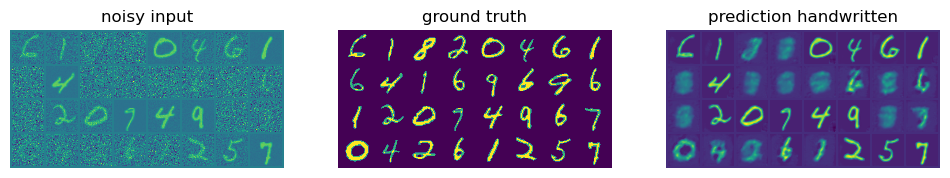

LOSS train 0.27033561386168004 valid 0.27416571974754333
EPOCH 15:
Iteration 3000


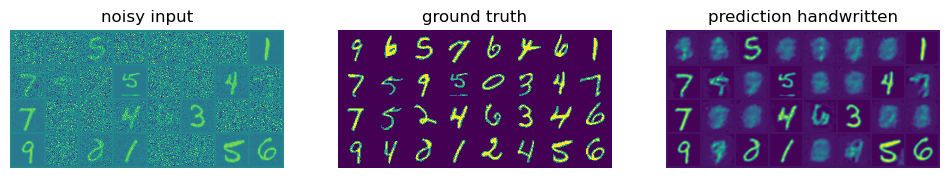

LOSS train 0.2768206425011158 valid 0.27122169733047485
EPOCH 16:
Iteration 3200


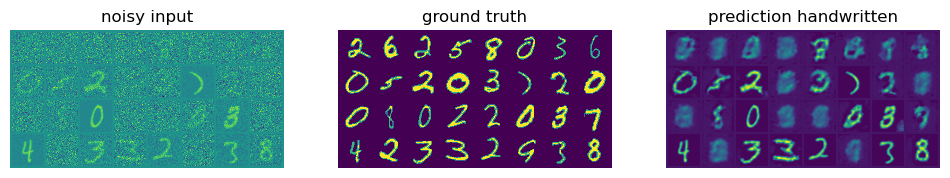

LOSS train 0.2648889280855656 valid 0.2647169530391693
EPOCH 17:
Iteration 3400


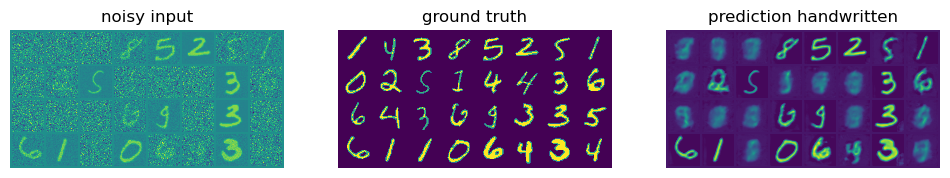

LOSS train 0.2683832566440105 valid 0.27011772990226746
EPOCH 18:
Iteration 3600


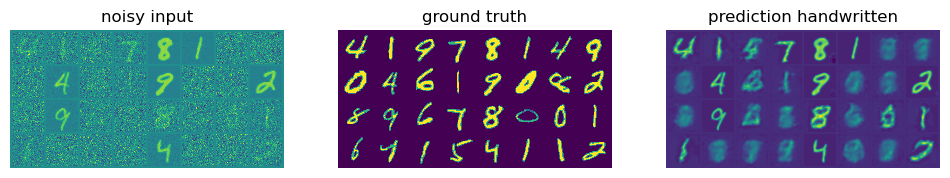

LOSS train 0.2702007689327002 valid 0.26609134674072266
Validation loss did not increase for 2 epochs, keeping checkpoint of epoch 16


In [3]:
import datetime 

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
EPOCHS = 20
best_vloss = 10000

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, iterations_per_epoch=200)

    running_vloss = 0.0

    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            batch, vlabels = vdata
            
            ground_truth = torch.round(batch)
            ground_truth = ground_truth.to(device)

            xt = preprocess(batch)
            xt = xt.to(device)

            prediction = model(xt)
            vloss = mse(prediction, ground_truth)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    if avg_vloss < best_vloss:
        vloss_count = 0
        best_vloss = avg_vloss
        model_path = 'denoising_unet.ckpt' # just saving best
        torch.save(model.state_dict(), model_path)
    else:
        vloss_count += 1
        if vloss_count == 2:
            print(f'Validation loss did not increase for 2 epochs, keeping checkpoint of epoch {epoch_number-2+1}')
            break

    epoch_number += 1